In [1]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [3]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [4]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [5]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
#     print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
#     print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [7]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [8]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [9]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

In [10]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 1


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

## Fanout, workload 1 at 30% + background traffic at 200Mbps - 40 flows 

In [11]:
simul_folder = "bkg200_fanout_wkld0_3_40flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,190)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,14592)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,107)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(30120,)
/TCP/
Mean Q length in Kbytes 19.486367952196762 and in packets 23.139635876001154
99th percentile in Kbytes 208.80247866287422 and in packets 253.12800315584207

Mean delay in us 155.8909436175741 and 99th percentile delay in us 1670.4198293029938

Background FCT (ms): mean: 102.20072119677297, 99th %: 237.51309053175822

Fanout max QCT (ms): mean: 0.5619334284892815, 99th %: 4.673470552429998

Fanout avg QCT (ms): mean: 0.33032095028170416, 99th %: 1.8968162308710776

Fanout min QCT (ms): mean: 0.28701872868038697, 99th %: 1.8208255730951366

Servers in deadline: mean: 36.401693227091634, 99th %: 0.0

(30120,)
/DCTCP30/
Mean Q length in Kbytes 3.6603786348214693 and in packets 4.421149341935568
99th percentile in Kbytes 23.653212155816004 and in packets 29.261593251409327

Mean delay in us 29.283029078571754 and 99th percentile delay in us 189.22569724652803

Background FCT (ms): mean: 100.22652722618729, 99th %: 217.8444254491119

Fanout max QCT (ms): mean: 0.27703885671401

## Fanout, workload 1 at 30% + background traffic at 400Mbps - 40 flows 

In [12]:
simul_folder = "bkg400_fanout_wkld0_3_40flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1028)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38172)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,544)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,68)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(30120,)
/TCP/
Mean Q length in Kbytes 46.97873086665541 and in packets 55.501915194613815
99th percentile in Kbytes 285.4179005597243 and in packets 337.1931536657918

Mean delay in us 375.8298469332433 and 99th percentile delay in us 2283.343204477794

Background FCT (ms): mean: 136.98074566207228, 99th %: 540.4461152793833

Fanout max QCT (ms): mean: 0.7509933019110293, 99th %: 6.823949478508144

Fanout avg QCT (ms): mean: 0.5825774613062429, 99th %: 2.896095784364921

Fanout min QCT (ms): mean: 0.5010165833188582, 99th %: 2.413704104602205

Servers in deadline: mean: 31.357005312084993, 99th %: 0.0

(30120,)
/DCTCP30/
Mean Q length in Kbytes 6.741502661835358 and in packets 8.136950402523428
99th percentile in Kbytes 20.85830447395064 and in packets 27.61113778284112

Mean delay in us 53.932021294682855 and 99th percentile delay in us 166.8664357916051

Background FCT (ms): mean: 137.95972822343236, 99th %: 552.1549558544814

Fanout max QCT (ms): mean: 0.3083695219497592, 99th %: 0

## Fanout, workload 1 at 30% + background traffic at 600Mbps - 40 flows 

In [13]:
simul_folder = "bkg600_fanout_wkld0_3_40flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2439)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,72058)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1344)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,90)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(30120,)
/TCP/
Mean Q length in Kbytes 83.86622231844949 and in packets 99.25065468542567
99th percentile in Kbytes 314.2380379227846 and in packets 371.0804890697878

Mean delay in us 670.9297785475959 and 99th percentile delay in us 2513.904303382277

Background FCT (ms): mean: 181.4811090119371, 99th %: 649.303917141167

Fanout max QCT (ms): mean: 1.1396549074374551, 99th %: 10.852123484878673

Fanout avg QCT (ms): mean: 0.9428976763483066, 99th %: 6.3154482614422935

Fanout min QCT (ms): mean: 0.8079945803428552, 99th %: 2.7387842242419254

Servers in deadline: mean: 24.408233731739706, 99th %: 0.0

(30120,)
/DCTCP30/
Mean Q length in Kbytes 10.048439416329106 and in packets 12.146742440215746
99th percentile in Kbytes 20.022570295496624 and in packets 27.01880237519188

Mean delay in us 80.38751533063285 and 99th percentile delay in us 160.180562363973

Background FCT (ms): mean: 188.2638838338186, 99th %: 656.1336771405996

Fanout max QCT (ms): mean: 0.33018683637319934, 99th %: 

In [14]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/TCP/': [(155.8909436175741, 1670.4198293029938), (375.8298469332433, 2283.343204477794), (670.9297785475959, 2513.904303382277)], '/DCTCP30/': [(29.283029078571754, 189.22569724652803), (53.932021294682855, 166.8664357916051), (80.38751533063285, 160.180562363973)], '/DCTCP_pacer_PQ/': [(0.37160913036627125, 7.677139690665741), (2.7765162323718613, 46.527697466519285), (9.384837058802217, 79.83771429450069)]}
--------bkg----------
{'/TCP/': [(102.20072119677297, 237.51309053175822), (136.98074566207228, 540.4461152793833), (181.4811090119371, 649.303917141167)], '/DCTCP30/': [(100.22652722618729, 217.8444254491119), (137.95972822343236, 552.1549558544814), (188.2638838338186, 656.1336771405996)], '/DCTCP_pacer_PQ/': [(203.62432708620076, 271.3777847169364), (240.15190344328929, 631.5107170068763), (289.00689864539504, 687.1717716292055)]}
--------fan_max----------
{'/TCP/': [(0.5619334284892815, 4.673470552429998), (0.7509933019110293, 6.823949478508144), (

/home/konspras/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


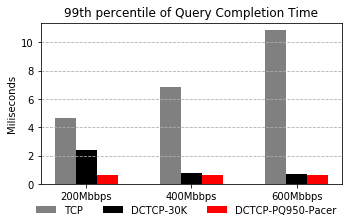

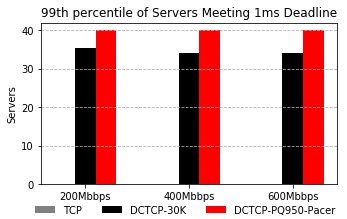

In [15]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
config_num = 3
ind = np.arange(config_num)
width = 0.2
x_axis_labels = ('200Mbbps', '400Mbbps', '600Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])

p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th percentile of Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
# ax1.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.09,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()

# # qct avg
# res = []
# for folder in results_folders:
#     res.append([x[1] for x in fanout_qct_avg[folder]])
# p1 = ax2.bar(ind-0.5*width, res[0], width, color='grey')
# p2 = ax2.bar(ind+0.5*width, res[1], width, color='k')
# p3 = ax2.bar(ind+1.5*width, res[2], width, color='r')


# ax2.set_title('99th percentile of Average Server Responses')
# ax2.set_xticks(ind + width / 2)
# ax2.set_xticklabels(x_axis_labels)
# # ax2.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
# ax2.set_ylabel('Miliseconds')
# ax2.yaxis.grid(linestyle="--")

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r')


ax3.set_title('99th percentile of Servers Meeting 1ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
# ax3.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='lower left')
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")



# # Switch Latency
# res = []
# for folder in results_folders:
#     res.append([x[1] for x in latency[folder]])
# p1 = ax4.bar(ind-0.5*width, res[0], width, color='grey',log=True)
# p2 = ax4.bar(ind+0.5*width, res[1], width, color='k',log=True)
# p3 = ax4.bar(ind+1.5*width, res[2], width, color='r',log=True)


# ax4.set_title('99th percentile of Switch Queuing Latency')
# ax4.set_xticks(ind + width / 2)
# ax4.set_xticklabels(x_axis_labels)
# # ax4.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='lower right')
# ax4.set_ylabel('Microseconds')
# ax4.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.09,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()

In [16]:
# fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,10))
# for i, setup in enumerate(results_folders):
#     ax1.bar(i-0.4, latency[setup][0][0], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.3, latency[setup][0][1], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.1, latency[setup][1][0], width=0.1, log=True, color="red")
#     ax1.bar(i, latency[setup][1][1], width=0.1, log=True, color="red")
#     ax1.bar(i+0.2, latency[setup][2][0], width=0.1, log=True, color="green")
#     ax1.bar(i+0.3, latency[setup][2][1], width=0.1, log=True, color="green")
# ax1.set_title("Switch Latency")
# ax1.legend(loc='upper left')
# ax1.set_ylabel('Queuing miliseconds')
# ax1.set_xlabel('Scheme')
# ax1.grid(which='major', linestyle="-")
# #ax1.grid(which='minor', linestyle='--')

# fig.tight_layout()   

# fig.savefig("Queuing delay vs Time.png", format="png")
# fig.show()